<a href="https://colab.research.google.com/github/hywkim-private/ALIGNet/blob/main/ALIGNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install imgaug

In [ ]:
pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=26f1834da478f203b058fa52d0c218463b216cfd5cb42651db9224b9419c322e
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import torch 
import torchvision
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2, wget
from zipfile import ZipFile
import h5py 
from imgaug import augmenters as iaa
from pathlib import Path
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import random_split
from torchsummary import summary

In [ ]:
#define hyper parameters 
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
EPOCHS = 5000
BATCH_SIZE = 5

TARGET_PROPORTION = 0.5
TARGET_PROPORTION_VAL = 0.5
TARGET_PROPORTION_TEST = 0.5
VAL_SIZE = 20
N_CLASS = 10
TEST_SIZE = 10
IMAGE_SIZE =128

#parameters for mask operation
MASK_SIZE = 60
MASK_STRIDE = 20

#parameters for the warp-field/grid
GRID_SIZE = 8


FILE_PATH = '../data/h5files'

In [ ]:
image_url = 'https://drive.google.com/uc?export=download&id=1Vv-Jz1VpI48MOVgK3Hq6ZYrs2NDP-FQ2'
filename = wget.download(image_url)
zf = ZipFile(filename, 'r')
zf.extractall('../data')
zf.close()

In [ ]:
#DATA LOADING ROUTINES

#This class must be fine-tuned after completing the model, so as to be able to read from any h5 input formats
class Load_HDF5(Dataset):
  # if get_all == True, file_path must specifiy a directory, if not, it should specify a file
  # the class will crash if this requirement is not met
  def __init__(self, file_path, get_all = False, transform = None):
    self.path = file_path
    self.transform = transform
    #if filename is None, perform a recursive search over the file directory and retrieve all .h5 files
    p = Path(file_path)
    if get_all == True:
      files = sorted(p.glob('*.h5'))
      data_list = []
      for file in files:
        data_list.append(self.get_file(str(file)))
      self.data = data_list
    else:
      self.data = self.get_file(str(file))

  #given a filepath, return the image object
  def get_file(self, path):
    with h5py.File(path, 'r') as file:
      data = file['dep']
      data = data.get('view1')[:]
      return data
    
  def __getitem__(self, index):
    if len(self.data) <= index:
      print("__getitem__ERROR: index out of range")
      return 
    else:
      x = self.data[index]
      x = x.astype('float32')
      if self.transform:
        x = self.transform(x)
      return x

  def __len__(self):
    return len(self.data)


#TODO: somehow after the deformation self.tarlist is empty wtf fix this
#given source and target img dataset, return a dict of augmented datasets
class Augment(Dataset):
  def __init__(self, tar_img, batch_size, im_size, augment_times=0, random_mask=0, elastic=False, grid_distort=False, rotate=False, scale=False, translate=False, shear=False):
    self.batch_size = batch_size
    self.transform = random_augmentation(elastic, grid_distort, rotate, scale, translate, shear)
    self.random_mask = random_mask + 1
    self.augment_times = augment_times + 1
    #first augment the original tar_list to match the returning batch size, then perform augmentation
    tar_list = []
    for i in range(len(tar_img) * self.random_mask * self.augment_times - 1):
      tar_list.append(tar_img)
    self.tar_list = torch.utils.data.ConcatDataset(tar_list)
    self.aug_list = torch.utils.data.ConcatDataset(tar_list)
    self.im_size = im_size

  def __getitem__(self, index):
    x = self.tar_list[index]
    y = self.aug_list[index]
    return x,y

  def __len__(self):
    return len(self.tar_list)

  #perform the deformation operation on batch of images
  #input shape: batchx 2xNxWxH
  def deform(self, aug_batch, tar_batch):
    aug_list = aug_batch
    tar_list = tar_batch
    if not (self.augment_times == None):
      aug_im = self.transform.augment_images(images=aug_batch)
      aug_list.append(aug_im)
      tar_list.append(tar_batch)
    return aug_list, tar_list

  #perform the mask operation on a batch 
  #input shape: batchx 2xNxWxH
  def mask(self, aug_batch, tar_batch):
    aug_list = aug_batch
    tar_list = tar_batch
    if not (self.random_mask == None):
      aug_im = random_mask_2d(self.im_size, aug_batch, square=True)
      aug_list.append(aug_im)
      tar_list.append(tar_batch)
    return aug_list, tar_list

  def collate_fn(self, batch):
    aug_batch, tar_batch = zip(*batch)
    aug_batch = list(aug_batch)
    tar_batch = list(tar_batch)
    #the batch will be a batchx2xNxWxH)

    aug_batch, tar_batch = self.deform(aug_batch, tar_batch)
    aug_batch, tar_batch = self.mask(aug_batch, tar_batch)
    
    return aug_batch, tar_batch
    
#The final function to get all the necessary data
def get_data():
  #H array containing both source and target images
  ds = Load_HDF5(FILE_PATH, get_all=True, transform=ToTensor())
  #split data into train, validation, test sets
  TRAIN_SIZE = len(ds)-VAL_SIZE-TEST_SIZE
  Trainset, Validset, Testset = random_split(ds,[TRAIN_SIZE, VAL_SIZE, TEST_SIZE])
  Trainset_target, Trainset_source = random_split(Trainset, [int(TRAIN_SIZE*TARGET_PROPORTION), int(TRAIN_SIZE*(1-TARGET_PROPORTION))])
  Validset_target, Validset_source = random_split(Validset, [int(VAL_SIZE*TARGET_PROPORTION_VAL), int(VAL_SIZE*(1-TARGET_PROPORTION_VAL))])
  Testset_target, Testset_source = random_split(Testset, [int(TEST_SIZE*TARGET_PROPORTION_TEST), int(TEST_SIZE*(1-TARGET_PROPORTION_TEST))])
  #Augment_data
  train_aug = Augment(Trainset_target,BATCH_SIZE, 128, augment_times = 4, random_mask = 4, elastic=True)
  valid_aug = Augment(Validset_target, BATCH_SIZE, 128, augment_times = 2, random_mask = 1, elastic=True)
  test_aug = Augment(Testset_target, BATCH_SIZE, 128, augment_times = 2, random_mask = 1, elastic=True)
 
  #define the dataloaders
  train_loader_target = DataLoader(train_aug, batch_size=BATCH_SIZE, collate_fn=train_aug.collate_fn, shuffle=True)
  train_loader_source = DataLoader(Trainset_source, batch_size=BATCH_SIZE, shuffle=True)
  valid_loader_target = DataLoader(valid_aug, batch_size=BATCH_SIZE, collate_fn=valid_aug.collate_fn, shuffle=True)
  print(len(valid_loader_target))
  valid_loader_source = DataLoader(Validset_source, batch_size=BATCH_SIZE, shuffle=True)
  test_loader_target = DataLoader(test_aug, batch_size=BATCH_SIZE, collate_fn=test_aug.collate_fn, shuffle=True)
  test_loader_source = DataLoader(Testset_source, batch_size=BATCH_SIZE, shuffle=True)
  return  train_loader_target, train_loader_source, valid_loader_target,valid_loader_source,test_loader_target,test_loader_source 

In [ ]:
#CORE HELPER FUNCTIONS

#initialize the differential grid
#the parameter learn offset will define whether or not to learn the offset values during training
def init_grid(grid_size):
  #spacing of the grid
  #-1 is because we have a1 = -1 (and thus there are grid_size - 1 "spacing" grids)
  delta = 2/(grid_size-1)
  np_grid = np.arange(grid_size, dtype=float)
  np_grid = np.full_like(np_grid,float(delta))
  ts_grid_x = torch.tensor(np_grid).to(DEVICE)
  ts_grid_y = torch.tensor(np_grid).to(DEVICE)
  ts_grid_x[0] = -1
  ts_grid_y[0] = -1
  diff_i_grid_y, diff_i_grid_x = torch.meshgrid(ts_grid_x,ts_grid_y)

  """  print(f'{diff_i_grid_x},{diff_i_grid_y}')"""  
  diff_grid = torch.stack([diff_i_grid_x, diff_i_grid_y])
  diff_grid = diff_grid.view(2*grid_size*grid_size)
  return diff_grid

#perform cumsum operation on a 2d batch of inputs
#takes in grid tensors of shape batch x 2 x grid x grid 
#return grid tensors of shape batch x 2 x grid x grid 
def cumsum_2d(grid, grid_offset_x, grid_offset_y):
  batch_size, dim, grid_1, grid_2 = grid.shape
  grid[:,0,:,0] = -1 
  grid[:,1,0,:] = -1 

  Integrated_grid_x = torch.cumsum(grid[:,0], dim = 2) + grid_offset_x
  Integrated_grid_y = torch.cumsum(grid[:,1], dim = 1) + grid_offset_y

  Integrated_grid = torch.stack([Integrated_grid_x, Integrated_grid_y])
  Integrated_grid = Integrated_grid.permute([1,0,2,3])

  return Integrated_grid

#visualize image given a data loader
def visualize_image(data_loader, plot_size):
  fig, ax = plt.subplots(plot_size, plot_size, figsize=(20,20))
  x = 0
  y = 0
  for i,batch_image in enumerate(data_loader):
    for k,image in enumerate(batch_image):
      image = image.squeeze()
      if x >= plot_size:
        x = 0
        y += 1
      if y >= plot_size:
        return
      ax[x,y].imshow(image, cmap='gray')
      x += 1

In [ ]:
tr_tar_dl, tr_src_dl, val_tar_dl, val_src_dl, test_tar_dl, test_src_dl = get_data()

visualize_image(val_tar_dl, 10)

Exception: ignored

In [ ]:

#DATA AUGMENTATION ROUTINES

#return target image as masked by random size and locations
#input: BxWxH
def random_mask_2d(target_size, target_image, square=True):
  x_coordinate = np.random.randint(target_size)
  y_coordinate = np.random.randint(target_size)
  mask_size_x = np.random.randint(target_size)
  mask_size_y = np.random.randint(target_size)
  if square:
    mask_size_x = np.random.randint(target_size)
    mask_size_y = mask_size_x
  end_coordinate_x = x_coordinate + mask_size_x if x_coordinate + mask_size_x < target_size else target_size
  end_coordinate_y = y_coordinate + mask_size_y if y_coordinate + mask_size_y < target_size else target_size
  masked_image = target_image.copy()
  masked_image[:][x_coordinate:end_coordinate_x,y_coordinate:end_coordinate_y] = 0
  #if the masked_image is same as the target_image, recursively apply the function again
  if masked_image == target_image:
    return random_mask_2d(target_size, target_image, square)
  return masked_image

#given an NxM image, detected the minimum gap between the edge of the image and the image pixel
def min_gap(image):
  N, M = image.shape
  #search the gap along the x_axis
  min_index_left_x = 0
  min_index_right_x = N-1
  for i in range(N-1):
    left_sum_x = sum(image[:,i])
    right_sum_x = sum(image[:,N-i-1])
    left_x_update = False
    right_x_update = False
    if left_sum_x != 0 and not left_x_update:
      min_index_left_x = i 
      left_x_update = True
    if right_sum_x != 0 and not right_x_update:
      min_index_right_x = N - i 
      right_x_update = True
    if left_x_update and right_x_update:
      break
  #search the gap along the y_axis
  min_index_upper_y = 0
  min_index_lower_y = M-1
  for k in range(M-1):
    upper_sum_y = sum(image[k,:])
    lower_sum_y = sum(image[M-k-1,:])
    upper_y_update = False
    lower_y_update = False
    if upper_sum_y != 0 and not upper_y_update:
      min_index_upper_y = k 
      upper_y_update = True
    if lower_sum_y != 0 and not lower_y_update:
      min_index_lower_y = M - k 
      lower_y_update = True
    if upper_y_update and lower_y_update:
      break
    
  return min_index_left_x, min_index_right_x, min_index_upper_y, min_index_lower_y
  

#randomly stretch image vertically or/and horizontally
#the transformation will be an affine transformation
#the transformation can either stretch inwards or outwards
#input WxH
def random_stretch (target_image, vertical=False, horizontal=False, stretch_inwards=False):
    W, H = target_image.shape
    grid_diff = 2/(W-1)
    min_index_left_x, min_index_right_x, min_index_upper_y, min_index_lower_y = min_gap(target_image)
    
    print(f'min_index_left_x: {min_index_left_x}, min_index_right_x: {min_index_right_x}, min_index_upper_y: {min_index_upper_y},  min_index_lower_y: { min_index_lower_y}')

    #define the limit range to which we will stretch the image
    limit_left_x = np.random.choice(np.arange(0,min_index_left_x),1).item()
    limit_right_x = np.random.choice(np.arange(min_index_right_x,W),1).item()
    limit_upper_y = np.random.choice(np.arange(0,min_index_upper_y),1).item()
    limit_lower_y = np.random.choice(np.arange(min_index_lower_y,H),1).item()
    stretch_center_x = int((limit_left_x + limit_right_x) / 2)
    evencenter_x = True if (limit_left_x + limit_right_x) % 2 == 0 else False 
    stretch_center_y = int((limit_upper_y + limit_lower_y) / 2)
    evencenter_y = True if (limit_upper_y + limit_lower_y) % 2 == 0 else False
    #define the differential scale we will add to scale window
    stretch_scale_left_x = grid_diff * (min_index_left_x - limit_left_x) / (stretch_center_x - min_index_left_x - (1 if evencenter_x else 0))
    stretch_scale_right_x = grid_diff * (limit_right_x - min_index_right_x) / (min_index_right_x - stretch_center_x + 1)
    stretch_scale_upper_y = grid_diff * (min_index_upper_y - limit_upper_y) / (stretch_center_y - min_index_upper_y - (1 if evencenter_y else 0))
    stretch_scale_lower_y = grid_diff * (limit_lower_y - min_index_lower_y) /  (min_index_right_x - stretch_center_x + 1)
    
    
    grid_x, grid_y = torch.meshgrid(torch.linspace(-1,1,W), torch.linspace(-1,1,H))
    target_image = target_image.unsqueeze(0).unsqueeze(0)
    if horizontal:
      """#apply the transformation to within the stretch window
      grid_x[:, limit_left_x : stretch_center_x - (min_index_left_x - limit_left_x) - (1 if evencenter_x else 0)] += stretch_scale_left_x * (min_index_left_x - limit_left_x)
      grid_x[:, stretch_center_x + (limit_right_x - min_index_right_x) + 1 : limit_right_x] -= stretch_scale_right_x * (limit_right_x - min_index_right_x)"""
    if vertical:
      start_upper_y = stretch_center_y - (min_index_upper_y - limit_upper_y)
      start_lower_y = stretch_center_y + (limit_lower_y - min_index_lower_y)
      for i in range(start_upper_y, limit_upper_y, -1):
        grid_y = grid_y.clone()
        grid_y[:, i] += stretch_scale_upper_y 
        grid = torch.stack([grid_x, grid_y])
        grid = grid.type(torch.FloatTensor).to(DEVICE)
        target_image = nn.functional.grid_sample(target_image.permute([1,0,2,3]).to(DEVICE), grid.unsqueeze(0).permute([0,2,3,1]))
        grid = grid.squeeze()
      for j in range(start_lower_y, limit_lower_y, 1):
        grid_y = grid_y.clone()
        grid_y[:, j] -= stretch_scale_lower_y 
        grid = torch.stack([grid_x, grid_y])
        grid = grid.type(torch.FloatTensor).to(DEVICE)
        target_image = nn.functional.grid_sample(target_image.permute([1,0,2,3]).to(DEVICE), grid.unsqueeze(0).permute([0,2,3,1]))
        grid = grid.squeeze()
    

    
    torch.set_printoptions(edgeitems=100)
    print(grid.shape)
    grid = grid.type(torch.FloatTensor).to(DEVICE)
    """ print(f'shape of grid: {grid.shape}')"""
    #perform the cumsum operation to restore the original grid from the differential grid
    return target_image


#given mask_size, target_size, stride, and target_image, create as many masked target images as possible and return its corresponding dataset
def mask_target_2d(mask_size, stride, target_size, target_image):
  #define parameters to fine-tune the masking operation
  remainder = target_size % mask_size
  max_iter = int(target_size / mask_size)

  #even_remainder denotes whether the remaining pixel after masking the input image is even (default=false)
  even_remainder = False
  if remainder % 2 == 0:
    even_remainder = True
  #convert target image to numpy in order to ease type conversions
  target_image = target_image.to(torch.device('cpu'))
  target_image = np.array(target_image)  
  starting_coordinate = [mask_size+int(remainder/2), mask_size+int(remainder/2)]
  #the current_coordinate denotes the upper-right-most coordinate of the mask 
  current_coordinate = [mask_size+int(remainder/2), mask_size+int(remainder/2)]
  #max_coordinate denotes the upper_right-most corner of the target image that the mask can reach
  max_coordinate = [target_size-int(remainder/2),target_size-int(remainder/2)]
  #dataset of masked images
  masked_arr = []
  #the first element of masked data will be the original image
  masked_arr.append(target_image.copy())
  #produce mask images until the mask reaches the upper_right corner of the target image (max_coordinate)
  while (current_coordinate[0] <= max_coordinate[0]) and (current_coordinate[1] <= max_coordinate[1]):
    #turn all areas within the masking target into zero
    masked_image = target_image.copy()
    masked_image[:,current_coordinate[0]-mask_size:current_coordinate[0],current_coordinate[1]-mask_size:current_coordinate[1]] = 0
    #add the masked image to data array--only if the masked image is different from the original image
    if not np.array_equal(masked_image, target_image):
      masked_arr.append(masked_image)
    #update current_coordinate along the x-axis
    current_coordinate[0] = current_coordinate[0] + stride
    #if the mask reaches the max of the x axis, move up to the y axis 
    if current_coordinate[0] >= max_coordinate[0]:
      current_coordinate[1] = current_coordinate[1] + stride
      current_coordinate[0] = starting_coordinate[0] 
  masked_arr = np.array(masked_arr)
  #just return the np object, not tensor
  return masked_arr
    


#return the pipeline of a transformation
#we will use albumentations library for this function
def random_augmentation(affine=False, elastic=False, grid_distort=False, rotate=False, scale=False, translate=False, shear=False):
  #define the transforamtion pipline 
  transform = iaa.Sequential (
  [
   iaa.Affine(scale=[0.5,1.5] if scale else None, translate_percent=[0.1, 0.5] if translate else None, rotate=[-360,360] if rotate else None, shear=[-45,45] if shear else None)
  ]
  )
  return transform



min_index_left_x: 3, min_index_right_x: 125, min_index_upper_y: 31,  min_index_lower_y: 97
torch.Size([2, 128, 128])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


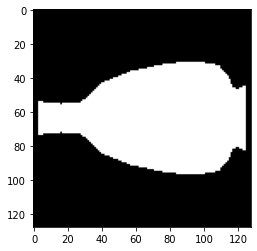

In [ ]:
test_image_batch = next(iter(train_loader_target))
test_image = next(iter(test_image_batch))

stretch_image = random_stretch(test_image.squeeze(), vertical=True)
test_image = test_image.to(torch.device('cpu')).detach().numpy()
stretch_image = stretch_image.to(torch.device('cpu')).detach().numpy()
plt.imshow(test_image.squeeze(),cmap='gray')




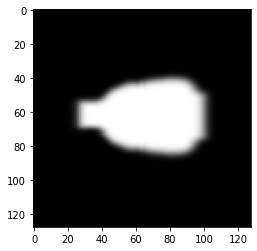

In [ ]:
plt.imshow(stretch_image.squeeze(),cmap='gray')

In [ ]:
#test cell for the function mask_target_2d
masked_ds = mask_target_2d(60, 20, 128, stretch_image)
masked_dl = DataLoader(masked_ds, batch_size=BATCH_SIZE, shuffle=True)
visualize_image(masked_dl, 10)

AttributeError: ignored

In [ ]:


#define the alignnet model
def get_conv(grid_size):
  model = nn.Sequential (
      nn.MaxPool2d (2),
      nn.Conv2d (2, 20, 5),
      nn.ReLU(),
      nn.MaxPool2d (2),
      nn.Conv2d (20, 20, 5),
      nn.ReLU(),
      nn.MaxPool2d (2),
      nn.Conv2d (20, 20, 2),
      nn.ReLU(),
      nn.MaxPool2d (2),
      nn.Conv2d (20, 20, 5),
      nn.ReLU(),
      
      #we need an Abs() functionality in order to ensure axial monotinicity
      #but will implement it in the network loop for readability 
  )
  return model

#define the model class
class ALIGNet(nn.Module):
    def __init__(self, grid_size):
      super().__init__()
      self.conv = get_conv(grid_size).to(DEVICE)
      self.flatten = nn.Flatten().to(DEVICE)
      self.linear1 = nn.Sequential(nn.Linear(80,20, bias = True),nn.ReLU(),).to(DEVICE)
      self.linear2 = nn.Linear(20, 2*grid_size*grid_size, bias=True).to(DEVICE)
      self.linear2.weights = init_grid(grid_size)
      self.grid_offset_x = torch.tensor(float(0), requires_grad=True).to(DEVICE)
      self.grid_offset_y = torch.tensor(float(0), requires_grad=True).to(DEVICE)
      self.grid_offset_x = nn.Parameter(self.grid_offset_x)
      self.grid_offset_y = nn.Parameter(self.grid_offset_y)
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x



#create and return a 2dimensional nxn grid (returns a vertically-stacked grid of x and y grid)
def get_grid(grid_size):
  grid_x, grid_y = torch.meshgrid(torch.linspace(-1,1,grid_size),torch.linspace(-1,1,grid_size))
  grid = torch.stack(grid_x, grid_y)
  return grid


#define a custom loss function, including the L1 regularization
#the warp field has the input format of Nx2xWxH
#Lambda is the regularization coefficient
def Total_Loss (target_image, warped_image, warp_field, grid_size, Lambda):
  batch,W,H = warped_image.shape
  L2_Loss_f = nn.MSELoss()
  L2_Loss = L2_Loss_f(target_image, warped_image)
  #create the identity grid
  #create the identity differential grid
  np_grid = np.arange(grid_size, dtype=float)
  np_grid = np.full_like(np_grid,float(2/grid_size))
  diff_i_grid_x, diff_i_grid_y = torch.meshgrid(torch.tensor(np_grid),torch.tensor(np_grid))
  diff_i_grid_x = diff_i_grid_x.unsqueeze(dim=0)
  diff_i_grid_y = diff_i_grid_y.unsqueeze(dim=0)
  diff_i_grid_x = diff_i_grid_x.to(DEVICE)
  diff_i_grid_y = diff_i_grid_y.to(DEVICE)
  #calculate the L1_Loss
  L1_Loss_f = nn.L1Loss()
  L_TV_Loss = L1_Loss_f(warp_field[:,0],diff_i_grid_x) + L1_Loss_f(warp_field[:,1],diff_i_grid_y)
  Total_loss = L2_Loss + Lambda * L_TV_Loss
  return Total_loss


def warp(model, source_image, masked_target, grid_size):
  input_image = torch.stack([source_image, masked_target])
  input_image  = input_image.permute([1,0,2,3])
  #run the network
  output_grid = model.forward(input_image)

  batch, grid = output_grid.shape

  """print(f'shape of output_grid {output_grid.shape}')"""

  output_grid = output_grid.view(batch, 2,grid_size,grid_size)
  #output_grid = output_grid.squeeze()
  #enforce axial monotinicity using the abs operation
  output_grid = torch.abs(output_grid)
  #perform the cumsum operation to restore the original grid from the differential grid
  integrated_grid = cumsum_2d(output_grid, model.grid_offset_x, model.grid_offset_y)

  """print(f'shape of Integrated_grid {integrated_grid.shape}')"""

  #Upsample the grid_size x grid_size warp field to image_size x image_size warp field
  #We will use bilinear upsampling
  #Integrated_grid = torch.unsqueeze(Integrated_grid, 0)
  Upsampler = nn.Upsample(size = [IMAGE_SIZE, IMAGE_SIZE], mode = 'bilinear')
  Upsampled_grid = Upsampler(integrated_grid)
  Upsampled_grid = Upsampled_grid.permute(0,2,3,1)
  Upsampled_grid = Upsampled_grid.float()
  
  #calculate target estimation
  Target_estimate = nn.functional.grid_sample(source_image.unsqueeze(0).permute([1,0,2,3]), Upsampled_grid)
  return output_grid, Target_estimate
   
#run the model for a single epoch
def run_epoch(model, optimizer, source_loader, target_loader, grid_size):

  
  masked_list = []
  target_list = []
  for index_target, target_image in enumerate(target_loader):
    _,_,img_size,img_size = target_image.shape
    target_image = target_image[0]
    target_image = np.array(target_image)
    #create a masked target loader for a single target (Bx N x Wx H)
    masked_ds = mask_target_2d(MASK_SIZE, MASK_STRIDE, IMAGE_SIZE, target_image)

    #under the assumption that the model is overfitting due to too many masked targets
    #we will reduce the size of mask by random sampling (uncomment the next line to use this func)
    #masked_ds, _ = random_split(masked_ds,[3, len(masked_ds)-3])
    #create target array and masked_array to make a dict of masked targets and original targets
    for i in range(len(masked_ds)-1):
      target_list.append(target_image)
      masked_list.append(masked_ds[i])

  target_list = np.array(target_list)
  masked_list = np.array(masked_list)
  #create a dictionary using the two lists
  masked_dict =  Mask_Dict(masked_list, target_list)
  masked_dl = DataLoader(masked_dict, batch_size=BATCH_SIZE, shuffle=True)
  #create iteration objects
  masked_iter = iter(masked_dl)
  source_iter = iter(source_loader)
  #we will save the average loss for seperate target images
  Loss_list = []
  #create iter objects of source and masked dict
  for i in range(len(masked_dl)-1):
    try:
      source_image = next(source_iter)
    except:
      source_iter = iter(source_loader)
      source_image = next(source_iter)
    masked_dict = next(masked_iter)
 
    masked_target = torch.FloatTensor(masked_dict['src']).squeeze(dim=1).to(DEVICE)
    target_image = torch.FloatTensor(masked_dict['tar']).squeeze(dim=1).to(DEVICE)
    optimizer.zero_grad()
    #list of loss for each masked_target image
    target_loss = []

    source_image = source_image.squeeze(dim=1)
    #vertically stack target and source images to feed into the model
    source_image = source_image.float().to(DEVICE)
    masked_target = masked_target.float().to(DEVICE)
    #break if there isn't enough masked_target left
    if masked_target.shape != source_image.shape:
      break

    #run forward propagation
    output_grid, Target_estimate = warp(model, source_image, masked_target,grid_size)        
    Target_estimate = Target_estimate.squeeze(dim=1)
    Total_loss = Total_Loss(target_image, Target_estimate, output_grid, grid_size, 1e-5)
    Total_loss.backward()
    optimizer.step()
    Loss_list.append(Total_loss)
  if Loss_list:
    #print(f'Loss for a target: {target_loss}')
    avg_loss = sum(Loss_list) / len(Loss_list)
  return Loss_list

def run_model(model,source_loader, target_loader, grid_size):
  optimizer = optim.Adam(model.parameters(), lr=1e-3)
  epoch_loss = []
  for i in range(EPOCHS):
    loss_list = run_epoch(model, optimizer, source_loader, target_loader, grid_size)
    avg_epoch_loss = sum(loss_list) / len(loss_list)
    epoch_loss.append(avg_epoch_loss)
    print(f'Loss in Epoch {i}: {avg_epoch_loss}')
  return epoch_loss

#------FROM HERE BELOW WE WILL DEFINE FUNCTIONS REQUIRED FOR VALIDATION-------

#visualize the results given source, target, and target estimate images
def visualize_results(source_image,  target_image, target_estimate):
  batch, _, _ = source_image.shape
  fig, ax = plt.subplots(batch, 3, figsize=(20,20))
  for i in range(batch):
    #ax[i,0].set_title('source_image')
    ax[i,0].imshow(source_image[i], cmap='gray')
    #ax[i,1].set_title('target_image')
    ax[i,1].imshow(target_image[i], cmap='gray')
    #ax[i,2].set_title('target_estimate')
    ax[i,2].imshow(target_estimate[i], cmap='gray')
  return

#given source and target validation  dataloaders, perform all validation operations
@torch.no_grad()
def validate(model, source_dl, target_dl, grid_size, visualize = False, get_loss = False):
  #we will run everything, save the results, and visualize the images all at once
  source = []
  target = []
  target_est = []
  loss_list = []
  for i, target_image in enumerate(target_dl):
    for k, source_image in enumerate(source_dl):
      source_image = torch.tensor(source_image)
      target_image = torch.tensor(target_image)
      source_image = source_image.squeeze().to(DEVICE)
      target_image = target_image.squeeze().to(DEVICE)

      output_grid, target_estimate = warp(model, source_image, target_image, grid_size)  

  
      
      if get_loss: 
        Total_loss = Total_Loss(target_image, target_estimate.squeeze(dim=1), output_grid, grid_size, 1e-5)
        loss_list.append(Total_loss)
      source_image = source_image.to(torch.device('cpu')).detach().numpy()
      target_image = target_image.to(torch.device('cpu')).detach().numpy()
      target_estimate = target_estimate.squeeze().to(torch.device('cpu')).detach().numpy()
      if visualize:
        source.append(source_image)
        target.append(target_image)
        target_est.append(target_estimate)
  if visualize:
    for i in range(len(source)):
      source_image = source[i]
      target_image = target[i]
      target_estimate = target_est[i]
      visualize_results(source_image, target_image, target_estimate)
  if get_loss:
    print(f'Average Loss: {sum(loss_list)/len(loss_list)}')

    

#TODO: Make it so that the model doesn't train all sources on a single target


In [ ]:

model = ALIGNet(GRID_SIZE)
e_loss =  run_model(model,train_loader_source, train_loader_target, GRID_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired

torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
Loss in Epoch 0: 0.3632142245769501
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
Loss in Epoch 1: 0.30733588337898254
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2])
torch.Size([10, 128, 128, 2

KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:246: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:247: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid b

Average Loss: 0.0961790531873703


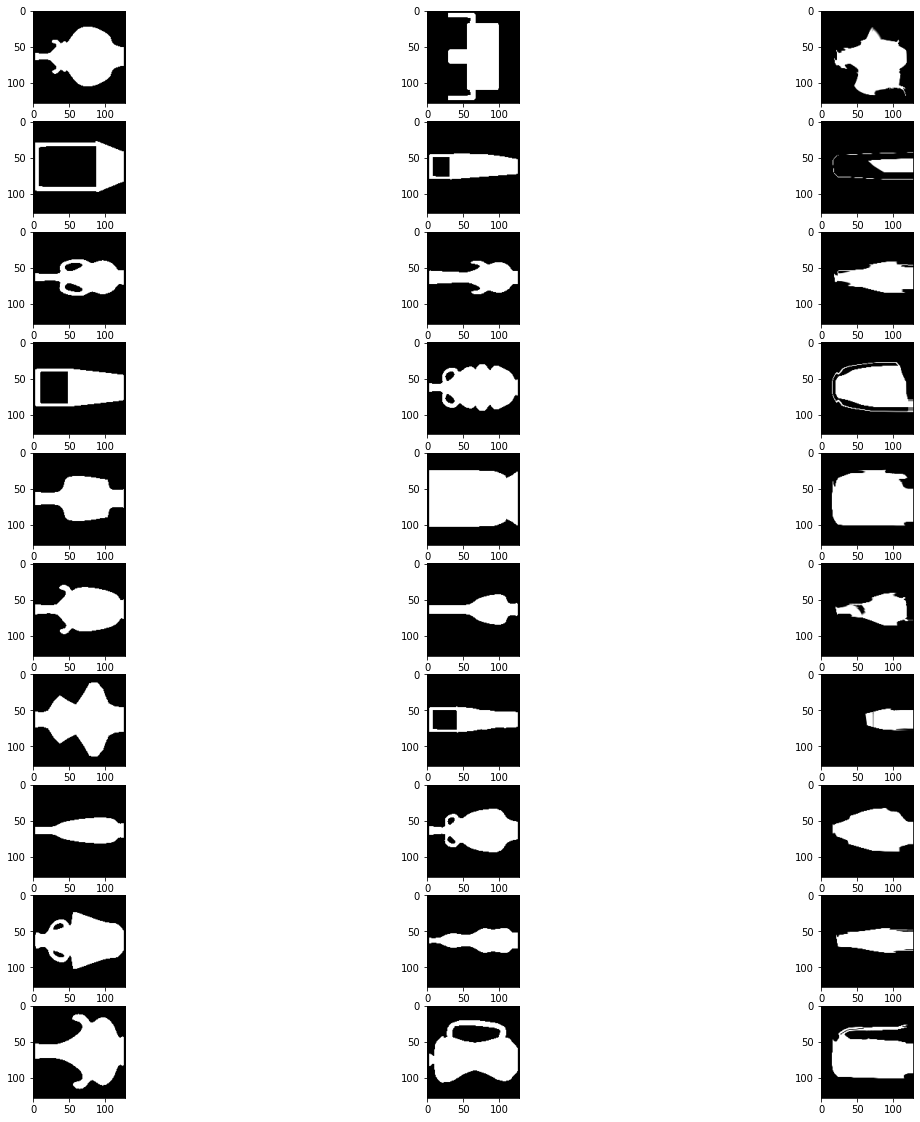

In [ ]:
validate(model,valid_loader_source, valid_loader_target, GRID_SIZE, visualize=True, get_loss=True)

In [ ]:
summary(model, (2, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         MaxPool2d-1            [-1, 2, 64, 64]               0
            Conv2d-2           [-1, 20, 60, 60]           1,020
              ReLU-3           [-1, 20, 60, 60]               0
         MaxPool2d-4           [-1, 20, 30, 30]               0
            Conv2d-5           [-1, 20, 26, 26]          10,020
              ReLU-6           [-1, 20, 26, 26]               0
         MaxPool2d-7           [-1, 20, 13, 13]               0
            Conv2d-8           [-1, 20, 12, 12]           1,620
              ReLU-9           [-1, 20, 12, 12]               0
        MaxPool2d-10             [-1, 20, 6, 6]               0
           Conv2d-11             [-1, 20, 2, 2]          10,020
             ReLU-12             [-1, 20, 2, 2]               0
          Flatten-13                   [-1, 80]               0
           Linear-14                   

In [ ]:
#save the current model
from google.colab import drive
drive.mount('/content/gdrive')
modelname = 'ALIGNet_model'
path = '{modelname}'
torch.save(model.state_dict(), 'ALIGNet_model')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#perform cumsum operation on a 2d batch of inputs
#takes in grid tensors of shape batch x 2 x grid x grid 
#return grid tensors of shape batch x 2 x grid x grid 
def cumsum(grid):

  Integrated_grid_x = torch.cumsum(grid[:,0], dim = 2)
  Integrated_grid_y = torch.cumsum(grid[:,1], dim = 1)
  Integrated_grid = torch.stack([Integrated_grid_x, Integrated_grid_y])
  return Integrated_grid

grid = np.ones([8,2,8,8])
grid = torch.tensor(grid)
print(cumsum(grid))

In [ ]:
ls


ALIGNet_model  data/     home/   media/  root/  sys/                usr/
bin/           datalab/  lib/    mnt/    run/   tensorflow-1.15.2/  var/
boot/          dev/      lib32/  opt/    sbin/  tmp/
content/       etc/      lib64/  proc/   srv/   tools/


In [ ]:
ls

bin/      datalab/  lib/    mnt/   run/   tensorflow-1.15.2/  var/
boot/     dev/      lib32/  opt/   sbin/  tmp/
content/  etc/      lib64/  proc/  srv/   tools/
data/     home/     media/  root/  sys/   usr/


In [ ]:
cd drive

[Errno 2] No such file or directory: 'drive'
/
